[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb)

# Example Notebook for Mechanistic Interpretability Assignment

Use this notebook as starter code for your Mechanistic Interpretability assignment. You should build your own tiny model on a tiny problem.

This could be:

* Counting 1s in binary strings (like shown here)

* Reversing short character sequences

* XOR or parity classification

* Or any other toy task you design yourself!


**Methods shown in this notebook:**
* Training a small MLP to solve a regression task (predicting the count of 1s)

* Visualizing hidden layer activations averaged by input type (number of 1s)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

**Additional methods you can try for your problem:**
* Inspecting activations for specific inputs (not just averaged)

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

* Perturbing inputs (e.g., flipping bits) to observe model robustness

* Comparing intermediate representations across training checkpoints

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

In [2]:
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(binary_str)
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)

### Build a Tiny MLP (multilayer perceptron) Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated Model for Regression
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # for interpretability

# Instantiate model
model = CountingMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")


CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.12343248724937439
Validation MAE: 0.28
Rounded Accuracy: 0.83


### Print Activations of a sample input

In [4]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")


Sample Input: tensor([[1., 0., 1., 0., 1., 1., 0., 0.]])
Hidden Layer Activations: tensor([[2.2580, 0.0000, 0.0000, 0.0000, 0.2068, 0.4226, 0.2810, 2.1187, 2.2822,
         0.0000]])
Output Logits: tensor([[4.1092]])
Rounded Prediction: 4


### Plot hidden activations across different numbers of 1s as input

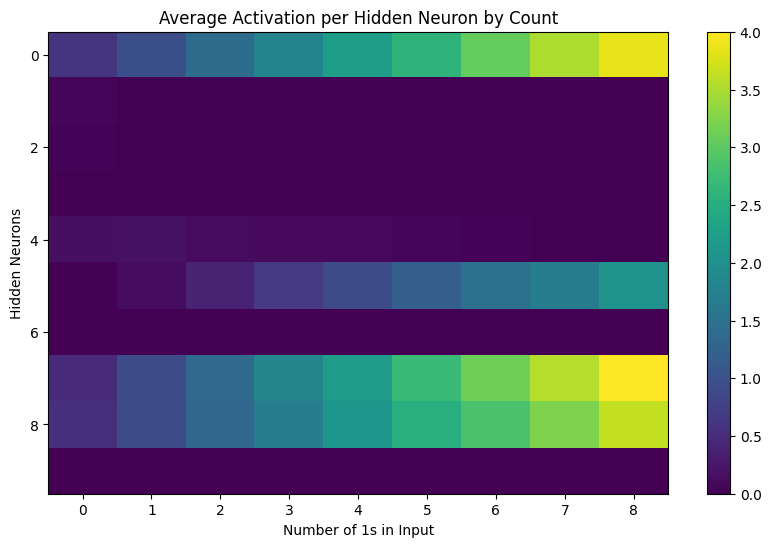

In [5]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, 10))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()

#### **What does this plot show us?**

##### *Neuron Specialization*
Look for rows (neurons) that are brightest at specific counts.

If a neuron appears consistently dark, that could mean it is unused or suppressed.

##### *Monotonic Trends*
If neurons show a gradual increase in activation with count — they may be learning a linear or thresholded count pattern.

That’s a great example of linearly increasing features often discussed in mechanistic interpretability (e.g. linear probe-ability).

##### *Redundant or Silent Units*
Some neurons may appear flatlined which possibly means they are unused due to redundancy. *What happens if you remove the neuron entirely?*

##### *Activation Superposition*
Some neurons activate across a range of counts, possibly blending multiple input features — this ties into superposition theory (see: Toy Models of Superposition)

_____________________

### Neuron Ablation (single neuron)

In [6]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)  # Example: 4 ones
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

# Zero out one neuron in the hidden layer (e.g., neuron 3)
neuron_to_zero = 3

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0  # zeroing neuron
    modified_output = model.fc2(h)
    modified_pred = modified_output.item()


print(f"True count: {true_count}")
print(f"Prediction (normal): {baseline_pred:.2f}")
print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

delta = modified_pred - baseline_pred
if delta > 0:
    print(f"➕ Prediction increased by {delta:.2f}")
elif delta < 0:
    print(f"➖ Prediction decreased by {abs(delta):.2f}")
else:
    print("⚖️ No change in prediction")


True count: 4
Prediction (normal): 4.24
Prediction (with neuron 3 zeroed): 4.24
⚖️ No change in prediction


#### **What does the ablation tell us?**

If the prediction changes significantly after zeroing out a neuron, that neuron likely plays an important functional role in the model’s decision!

### Neuron Ablation (sweep of neurons)

🧾 True count: 4, Baseline prediction: 4.24


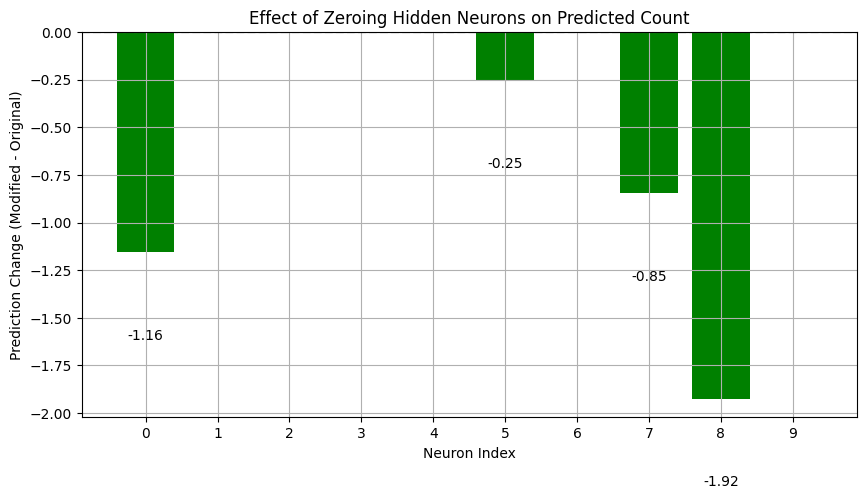

Neuron 0 → Prediction decreased by 1.16
Neuron 5 → Prediction decreased by 0.25
Neuron 7 → Prediction decreased by 0.85
Neuron 8 → Prediction decreased by 1.92


In [7]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction
neuron_indices = list(range(model.fc1.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(test_input))
        h[:, i] = 0  # zero out neuron i
        mod_output = model.fc2(h)
        mod_pred = mod_output.item()
        signed_deltas.append(mod_pred - baseline_pred)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
plt.grid(True)

# Annotatation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top')

plt.show()

# Summary
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")


#### **What does the sweep of neuron ablations tell us?**

Which neurons had the most impact on predictions?

Are there redundant neurons (zeroing them causes no change)?